# 1. Loading libraries

In [44]:
import os
import pandas as pd
import numpy as np
import warnings
from IPython.display import display
import pyreadstat

from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

import matplotlib.pyplot as plt
import seaborn as sns
import math
from itertools import combinations

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules

from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination
from pgmpy.factors.discrete import TabularCPD

# 2. Data Processing

In [45]:
df, meta = pyreadstat.read_sav('lcfs_2021_dvhh_ukanon.sav')

merged_df = pd.merge(df, df, on='case', how='left')

In [46]:
df, meta = pyreadstat.read_sav('lcfs_2021_dvhh_ukanon.sav')

columns_to_extract = [
    'P532', 'CK1315', 'A049', 'CB1127', 'C51113', 'C93411w', 'C51114w',
    'C93111', 'B105', 'B270', 'C21311', 'B190', 'B231', 'B181'
]

new_df = df[columns_to_extract]

new_df.to_csv('data_extracted.csv', index=False)

print(new_df)

        P532  CK1315  A049  CB1127  C51113  C93411w  C51114w  C93111   B105  \
0       0.00     0.0   5.0   0.000     0.0    0.000      0.0     3.0   0.00   
1       0.00     0.0   2.0  14.300     0.0    0.000      0.0     0.0   0.00   
2     107.09     0.0   2.0   0.000     0.0    0.000      0.0     0.0   0.00   
3     178.40     0.0   4.0  28.225     0.0    0.000      0.0     0.0   0.00   
4      15.38     0.0   2.0   4.875     0.0   16.495      0.0     0.0  15.38   
...      ...     ...   ...     ...     ...      ...      ...     ...    ...   
5627    0.00     0.0   4.0  23.730     0.0    0.000      0.0     0.0   0.00   
5628   58.58     0.0   3.0  28.745     0.0    3.640      0.0     4.0  58.58   
5629  151.17     0.0   3.0   2.495     0.0    0.000      0.0     0.5   0.00   
5630    0.00     0.0   2.0   0.000     0.0    0.000      0.0     0.0   0.00   
5631   77.54     0.0   3.0   0.000     0.0    0.000      0.0     0.0   0.00   

        B270  C21311  B190   B231  B181  
0       0

In [47]:
column_rename_map = {
    'P532': 'dwel_improve',
    'C51113': 'decor',
    'CK1315': 'capital_improve',
    'B105': 'exten',
    'CB1127': 'takeaway',
    'C93111': 'game',
    'B190': 'video_online',
    'C93411w': 'petfood_internet',
    'C51114w': 'garden_fur_internet',
    'C21311': 'beer_home',
    'B270': 'fur',
    'B231': 'gas_elect',
    'B181': 'tvlicence',
    'A049': 'household_size'
}

new_df = new_df.rename(columns=column_rename_map)
print(new_df)

      dwel_improve  capital_improve  household_size  takeaway  decor  \
0             0.00              0.0             5.0     0.000    0.0   
1             0.00              0.0             2.0    14.300    0.0   
2           107.09              0.0             2.0     0.000    0.0   
3           178.40              0.0             4.0    28.225    0.0   
4            15.38              0.0             2.0     4.875    0.0   
...            ...              ...             ...       ...    ...   
5627          0.00              0.0             4.0    23.730    0.0   
5628         58.58              0.0             3.0    28.745    0.0   
5629        151.17              0.0             3.0     2.495    0.0   
5630          0.00              0.0             2.0     0.000    0.0   
5631         77.54              0.0             3.0     0.000    0.0   

      petfood_internet  garden_fur_internet  game  exten     fur  beer_home  \
0                0.000                  0.0   3.0   0.00

In [48]:
print(new_df.dtypes)

dwel_improve           float64
capital_improve        float64
household_size         float64
takeaway               float64
decor                  float64
petfood_internet       float64
garden_fur_internet    float64
game                   float64
exten                  float64
fur                    float64
beer_home              float64
video_online           float64
gas_elect              float64
tvlicence              float64
dtype: object


In [49]:
new_df_transfered = new_df.astype(int)

In [50]:
print(new_df_transfered.dtypes)
new_df_transfered.to_csv('data_extracted_transfered.csv', index=False)

dwel_improve           int64
capital_improve        int64
household_size         int64
takeaway               int64
decor                  int64
petfood_internet       int64
garden_fur_internet    int64
game                   int64
exten                  int64
fur                    int64
beer_home              int64
video_online           int64
gas_elect              int64
tvlicence              int64
dtype: object


## 2.2 Address missing data

In [51]:
print(new_df_transfered)

      dwel_improve  capital_improve  household_size  takeaway  decor  \
0                0                0               5         0      0   
1                0                0               2        14      0   
2              107                0               2         0      0   
3              178                0               4        28      0   
4               15                0               2         4      0   
...            ...              ...             ...       ...    ...   
5627             0                0               4        23      0   
5628            58                0               3        28      0   
5629           151                0               3         2      0   
5630             0                0               2         0      0   
5631            77                0               3         0      0   

      petfood_internet  garden_fur_internet  game  exten  fur  beer_home  \
0                    0                    0     3      0   

dwel_improve: 384 outliers, 6.82% of total
capital_improve: 43 outliers, 0.76% of total
household_size: 24 outliers, 0.43% of total
takeaway: 1123 outliers, 19.94% of total
decor: 640 outliers, 11.36% of total
petfood_internet: 260 outliers, 4.62% of total
garden_fur_internet: 15 outliers, 0.27% of total
game: 1061 outliers, 18.84% of total
exten: 1059 outliers, 18.80% of total
fur: 1031 outliers, 18.31% of total
beer_home: 1108 outliers, 19.67% of total
video_online: 926 outliers, 16.44% of total
gas_elect: 54 outliers, 0.96% of total
tvlicence: 534 outliers, 9.48% of total


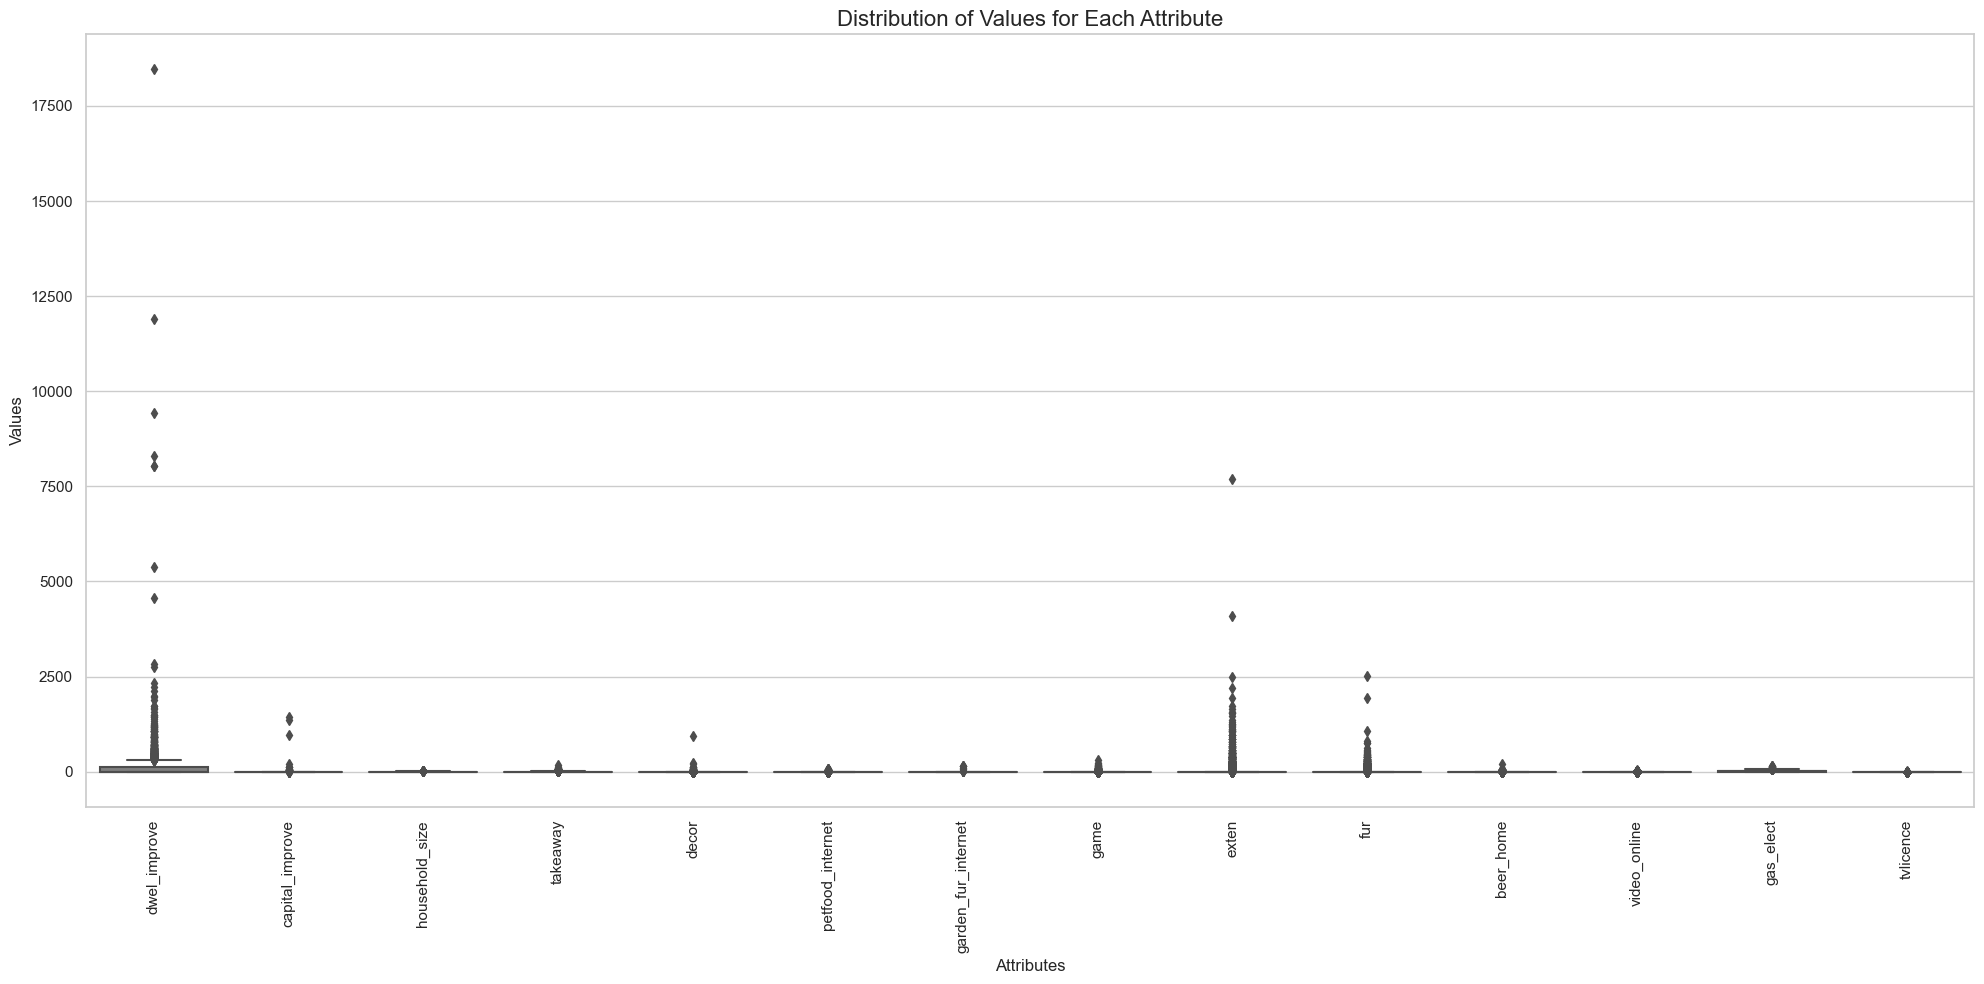

In [52]:
columns_to_plot = [col for col in new_df_transfered.columns]

outlier_info = {}
for column in columns_to_plot:
    Q1 = new_df_transfered[column].quantile(0.25)
    Q3 = new_df_transfered[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = new_df_transfered[(new_df_transfered[column] < lower_bound) | (new_df_transfered[column] > upper_bound)]
    outlier_count = outliers.shape[0]
    total_count = new_df_transfered[column].shape[0]
    outlier_percentage = (outlier_count / total_count) * 100
    outlier_info[column] = {'count': outlier_count, 'percentage': outlier_percentage}

for column, info in outlier_info.items():
    print(f"{column}: {info['count']} outliers, {info['percentage']:.2f}% of total")

melted_data = pd.melt(new_df_transfered[columns_to_plot])

plt.figure(figsize=(20, 10))
sns.boxplot(x='variable', y='value', data=melted_data, color='gray')

plt.title('Distribution of Values for Each Attribute', fontsize=16)
plt.xlabel('Attributes', fontsize=12)
plt.ylabel('Values', fontsize=12)

plt.xticks(rotation=90)

plt.tight_layout()

plt.savefig("/Users/phoebeyang/Desktop/Distribution of Values for Each Attribute.png")
plt.show()

In [53]:
quantiles = new_df_transfered[columns_to_plot].quantile([0.005, 0.995])

extreme_outlier_info = {}
for column in columns_to_plot:
    lower_bound = quantiles.loc[0.005, column]
    upper_bound = quantiles.loc[0.995, column]
    extreme_outliers = new_df_transfered[(new_df_transfered[column] < lower_bound) | (new_df_transfered[column] > upper_bound)]
    extreme_outlier_count = extreme_outliers.shape[0]
    total_count = new_df_transfered[column].shape[0]
    extreme_outlier_percentage = (extreme_outlier_count / total_count) * 100
    extreme_outlier_info[column] = {'count': extreme_outlier_count, 'percentage': extreme_outlier_percentage}

for column, info in extreme_outlier_info.items():
    print(f"{column}: {info['count']} extreme outliers, {info['percentage']:.2f}% of total")

dwel_improve: 29 extreme outliers, 0.51% of total
capital_improve: 26 extreme outliers, 0.46% of total
household_size: 24 extreme outliers, 0.43% of total
takeaway: 29 extreme outliers, 0.51% of total
decor: 27 extreme outliers, 0.48% of total
petfood_internet: 23 extreme outliers, 0.41% of total
garden_fur_internet: 15 extreme outliers, 0.27% of total
game: 29 extreme outliers, 0.51% of total
exten: 29 extreme outliers, 0.51% of total
fur: 29 extreme outliers, 0.51% of total
beer_home: 28 extreme outliers, 0.50% of total
video_online: 28 extreme outliers, 0.50% of total
gas_elect: 29 extreme outliers, 0.51% of total
tvlicence: 1 extreme outliers, 0.02% of total


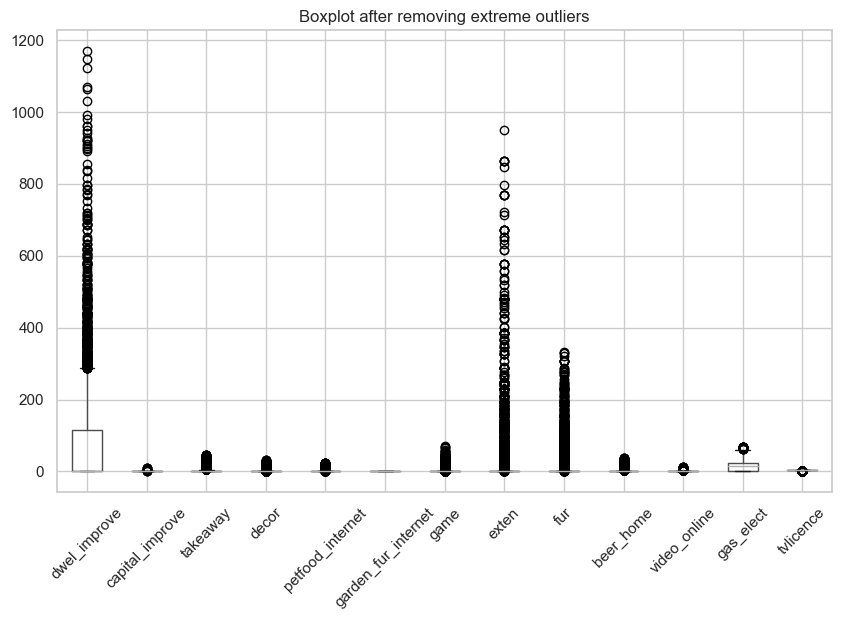

      dwel_improve  capital_improve  household_size  takeaway  decor  \
0                0                0               5         0      0   
1                0                0               2        14      0   
2              107                0               2         0      0   
3              178                0               4        28      0   
4               15                0               2         4      0   
...            ...              ...             ...       ...    ...   
5627             0                0               4        23      0   
5628            58                0               3        28      0   
5629           151                0               3         2      0   
5630             0                0               2         0      0   
5631            77                0               3         0      0   

      petfood_internet  garden_fur_internet  game  exten  fur  beer_home  \
0                    0                    0     3      0   

In [54]:
columns_to_ignore = ['household_structure', 'household_size']
columns_to_process = [col for col in columns_to_plot if col not in columns_to_ignore]

rows_to_delete = set()
for column in columns_to_process:
    lower_bound = quantiles.loc[0.005, column]
    upper_bound = quantiles.loc[0.995, column]
    extreme_outliers = new_df_transfered[(new_df_transfered[column] < lower_bound) | (new_df_transfered[column] > upper_bound)]
    rows_to_delete.update(extreme_outliers.index)

new_df_cleaned = new_df_transfered.drop(index=rows_to_delete)

plt.figure(figsize=(10, 6))
new_df_cleaned.boxplot(column=columns_to_process)
plt.title('Boxplot after removing extreme outliers')
plt.xticks(rotation=45)
plt.show()

print(new_df_cleaned)

## 2.3 Extend the dataset

In [55]:
import csv
import json

def read_csv_to_dict(file_path):
    data = {}
    
    with open(file_path, 'r', newline='', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        
        for field in reader.fieldnames:
            data[field] = []
        
        for row in reader:
            for field in reader.fieldnames:
                try:
                    value = int(row[field])
                except ValueError:
                    value = row[field]
                data[field].append(value)
    
    return data

file_path = 'data_extracted_transfered.csv'
dictionary = read_csv_to_dict(file_path)

with open('output_data.json', 'w', encoding='utf-8') as f:
    json.dump(dictionary, f, indent=4)

In [56]:
new_df_transformed = pd.DataFrame(dictionary)

result = pd.DataFrame()

for index, row in new_df_transformed.iterrows():
    max_value = row.max()  
    expanded_data = {}
    for col in new_df_transformed.columns:
        expanded_array = np.zeros(max_value, dtype=int)
        expanded_array[:int(row[col])] = 1
        expanded_data[col] = expanded_array

    expanded_df = pd.DataFrame(expanded_data)
    result = pd.concat([result, expanded_df], ignore_index=True)
    
print(result)

result.to_excel("expanded_data.xlsx", index=False)
print("Data has been saved as: expanded_data.xlsx")

        dwel_improve  capital_improve  household_size  takeaway  decor  \
0                  0                0               1         0      0   
1                  0                0               1         0      0   
2                  0                0               1         0      0   
3                  0                0               1         0      0   
4                  0                0               1         0      0   
...              ...              ...             ...       ...    ...   
649627             1                0               0         0      0   
649628             1                0               0         0      0   
649629             1                0               0         0      0   
649630             1                0               0         0      0   
649631             1                0               0         0      0   

        petfood_internet  garden_fur_internet  game  exten  fur  beer_home  \
0                      0         

# 3. EDA

In [57]:
summary_stats = new_df.describe()
print(summary_stats)

group1_vars = ['dwel_improve', 'capital_improve', 'decor', 'exten']
group1_avg = new_df[group1_vars].sum(axis=1).mean() / len(group1_vars)
print(f"\nHouse Improvement Expenditure Attributes: {group1_avg}")

group2_vars = ['takeaway', 'fur', 'garden_fur_internet', 'petfood_internet', 'game', 
               'beer_home', 'video_online', 'tvlicence', 'gas_elect']
group2_avg = new_df[group2_vars].sum(axis=1).mean() / len(group2_vars)
print(f"Stay-at-home Expenditure Attributes: {group2_avg}")

       dwel_improve  capital_improve  household_size     takeaway  \
count   5632.000000      5632.000000     5632.000000  5632.000000   
mean      99.658227         0.913156        2.280185     3.676286   
std      419.749291        29.745181        1.202161     8.886619   
min        0.000000         0.000000        1.000000     0.000000   
25%        0.000000         0.000000        1.000000     0.000000   
50%        0.000000         0.000000        2.000000     0.000000   
75%      123.080000         0.000000        3.000000     2.881250   
max    18461.540000      1446.026026        9.000000   181.095000   

             decor  petfood_internet  garden_fur_internet         game  \
count  5632.000000       5632.000000          5632.000000  5632.000000   
mean      1.215694          0.479608             0.129983     2.365862   
std      14.017195          3.396380             3.688455    10.805222   
min       0.000000          0.000000             0.000000     0.000000   
25%     

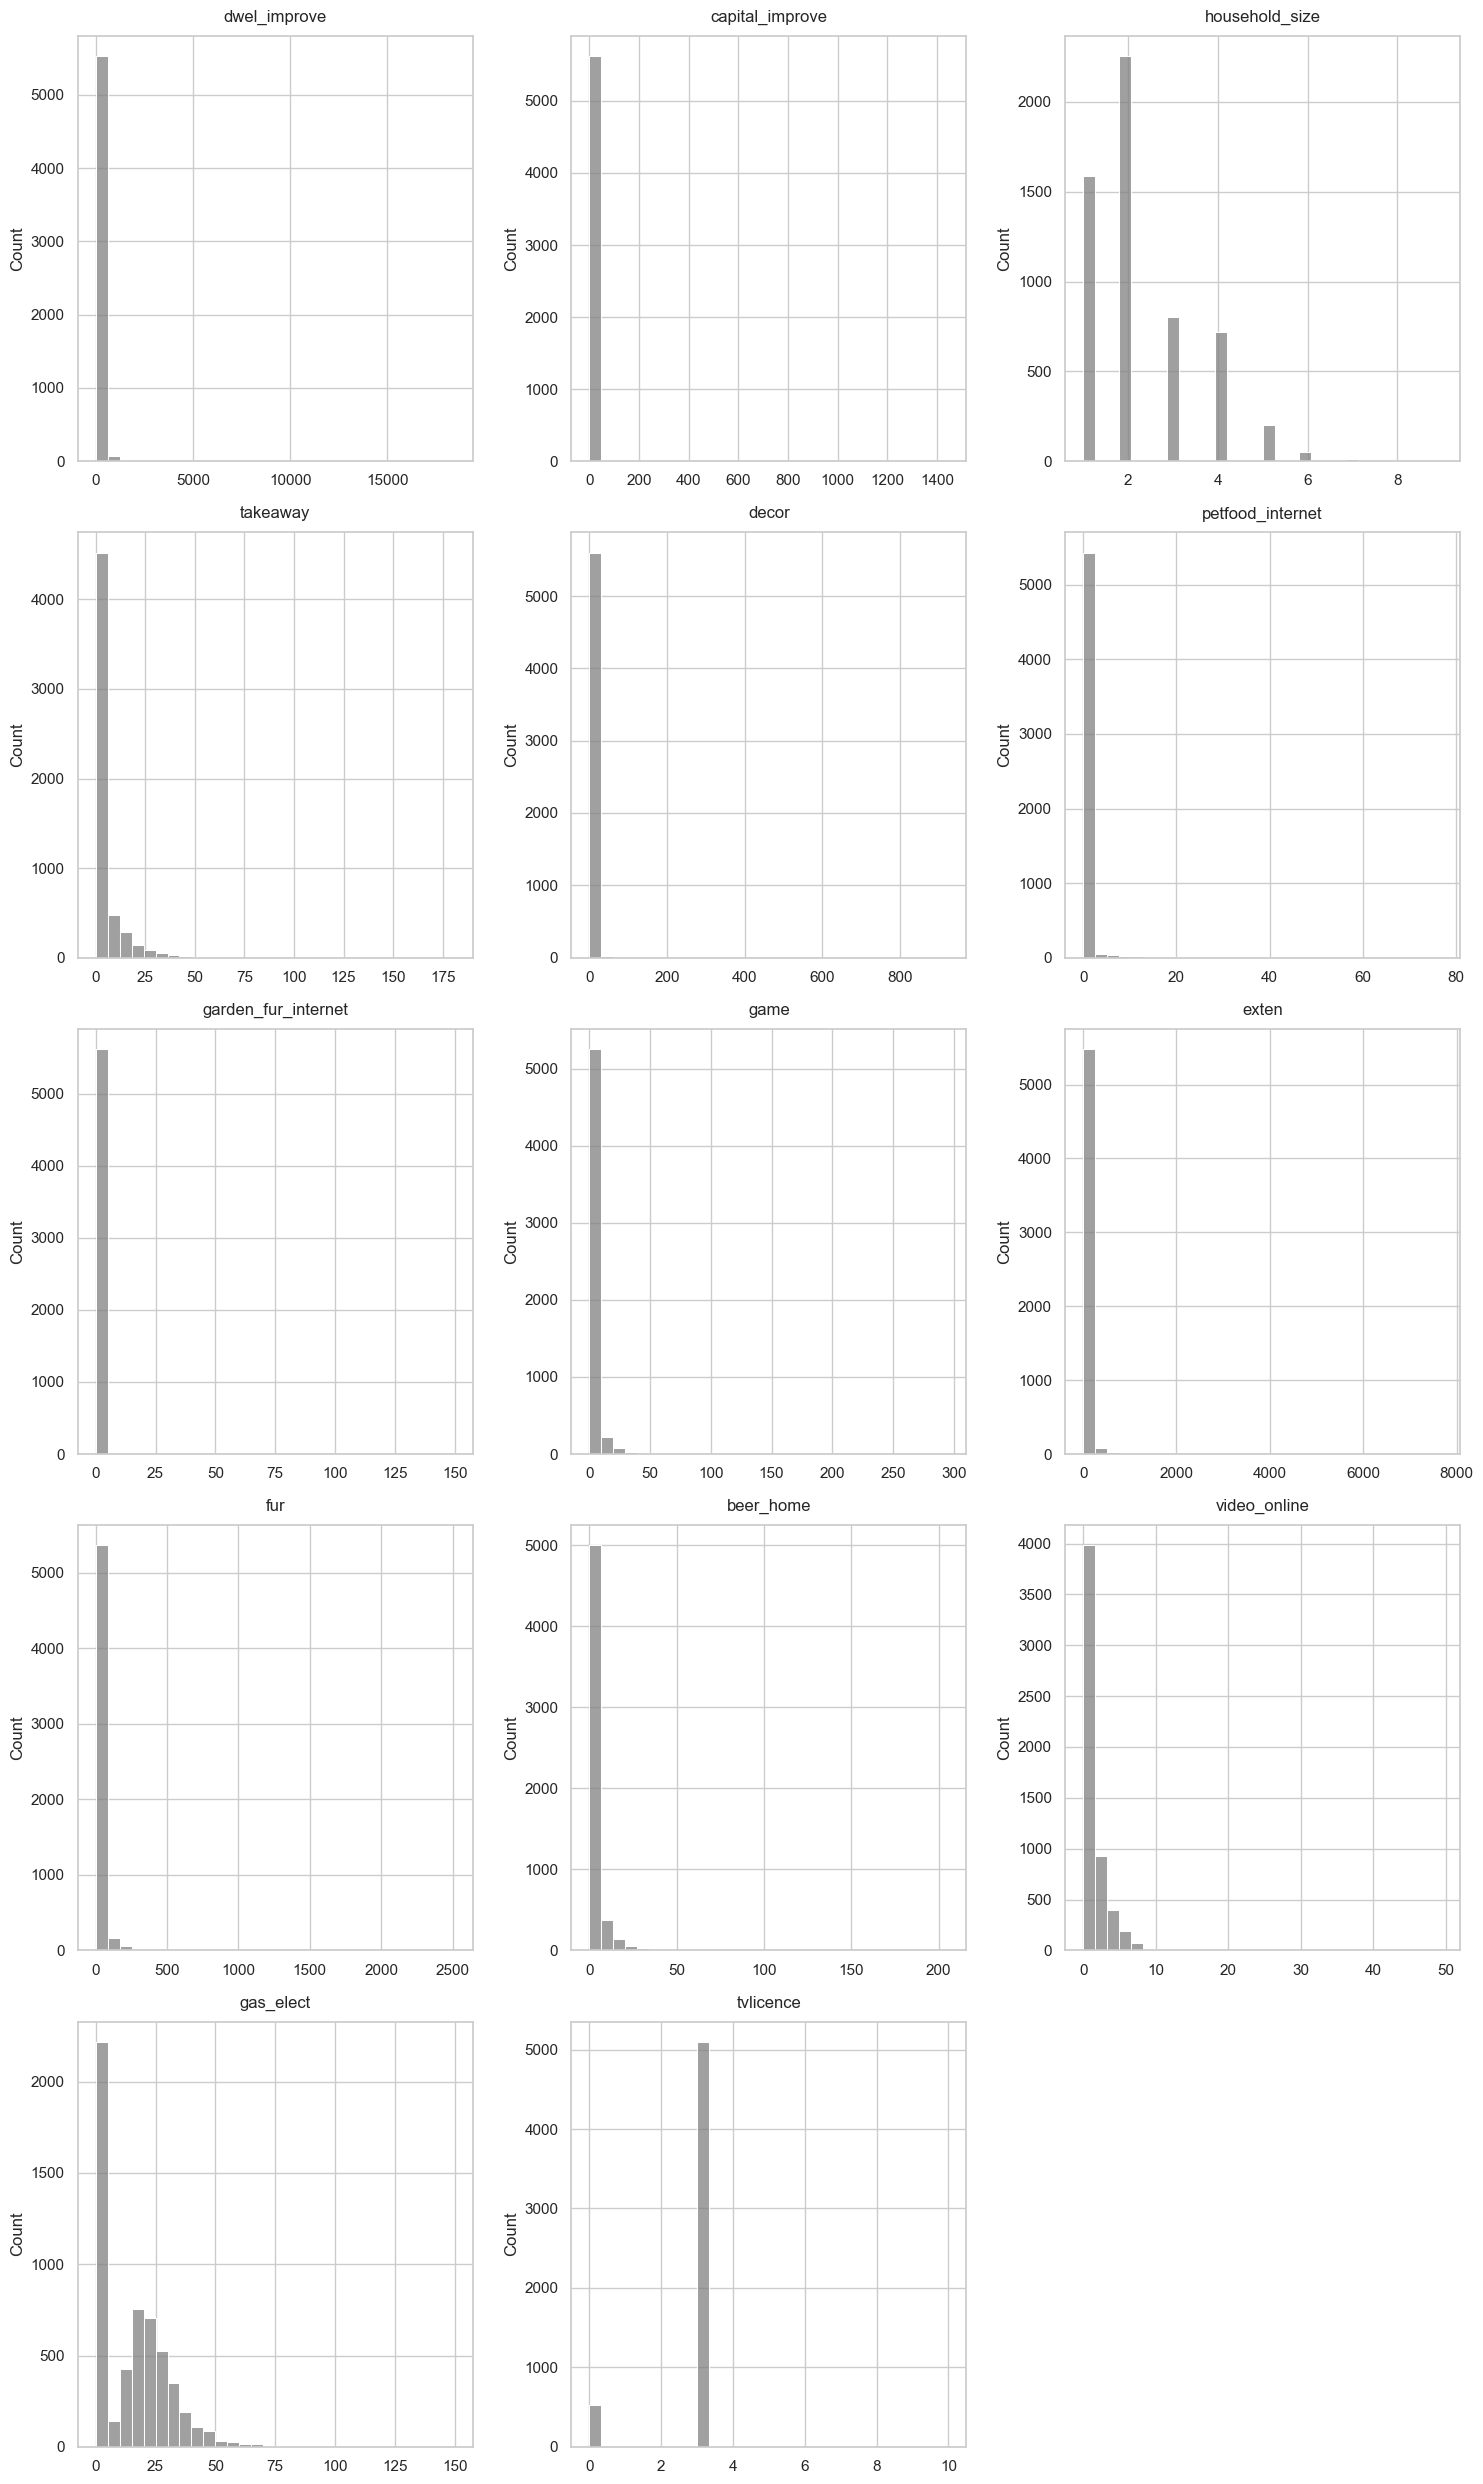

In [58]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set(style="whitegrid")

# Calculate the number of rows and columns
n_cols = 3  # You can change this to 4 if you prefer 4 columns
n_rows = math.ceil(len(new_df.columns) / n_cols)

# Create the subplot grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(15, 5*n_rows))

# Flatten the axes array for easier iteration
axes = axes.flatten()

for i, column in enumerate(new_df.columns):
    sns.histplot(new_df[column], bins=30, color='grey', ax=axes[i])
    
    # Move the x-label to the top of the plot
    axes[i].set_xlabel('')
    axes[i].set_title(column, pad=10)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("/Users/phoebeyang/Desktop/subplots.png")
plt.show()

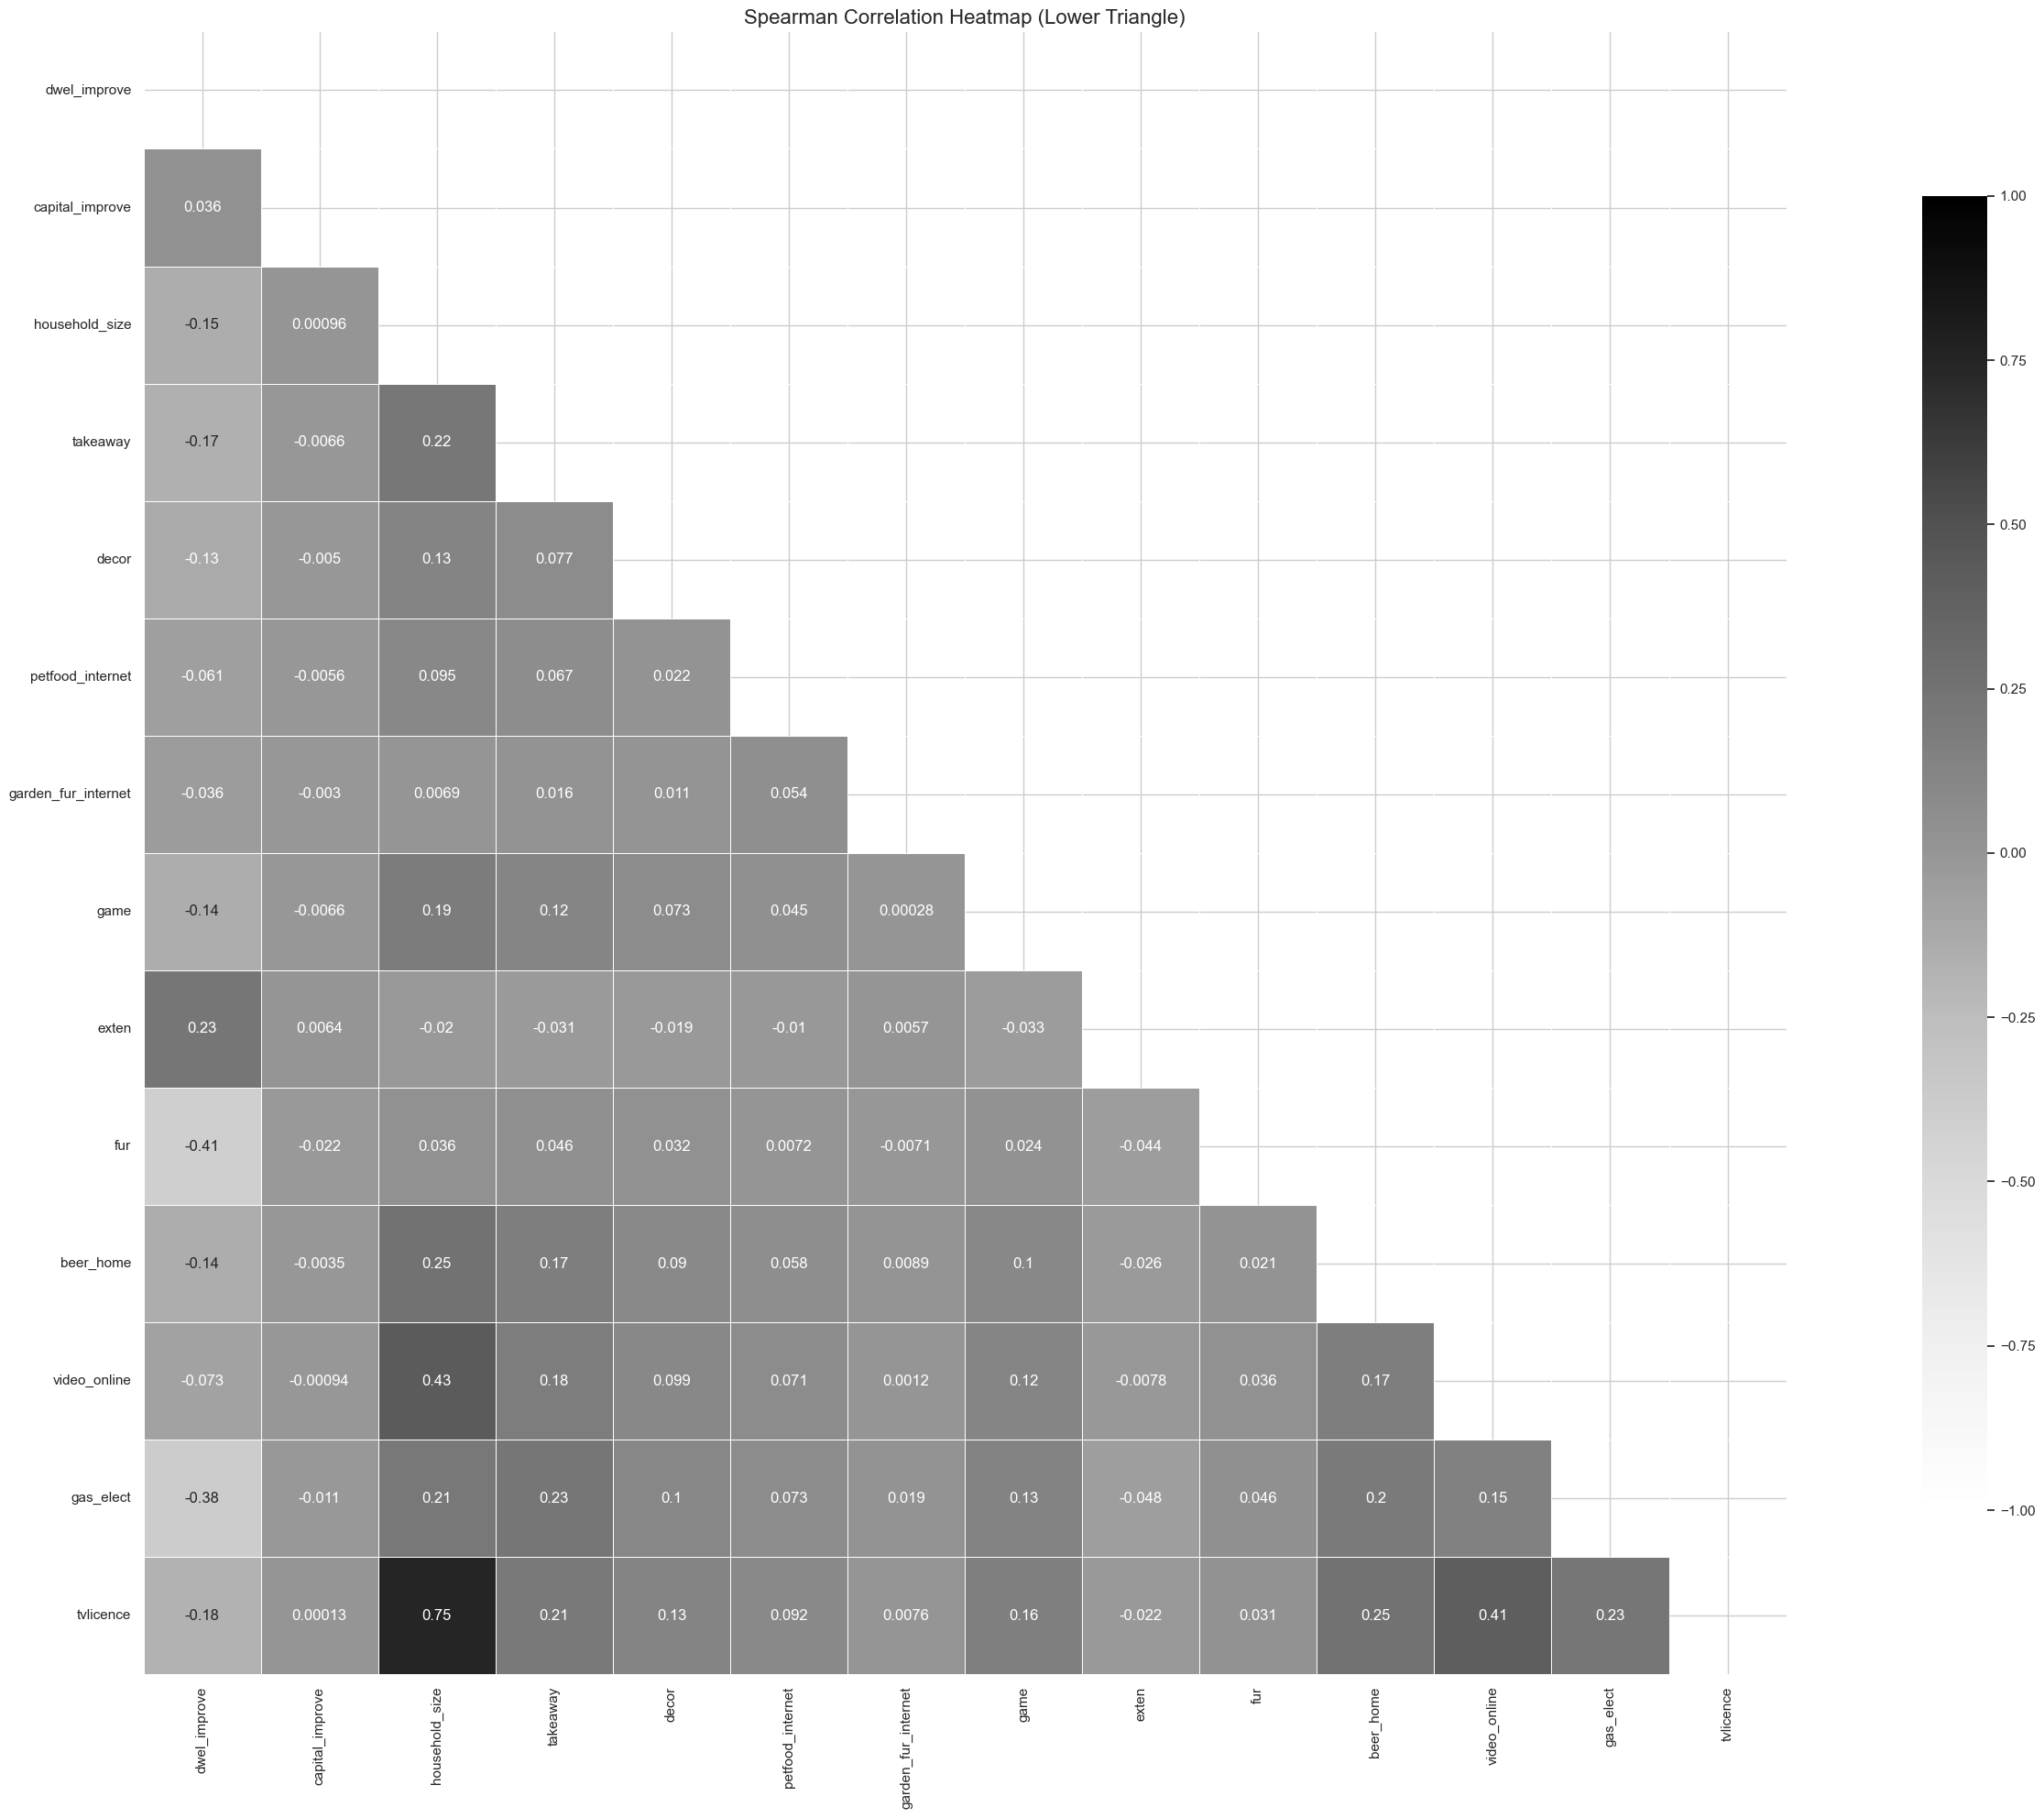

In [59]:
file_path = "expanded_data.xlsx"
data_standardized = pd.read_excel(file_path)

correlation_data = data_standardized.select_dtypes(include=[np.number])
correlation_matrix = correlation_data.corr(method='spearman')

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, 
            mask=mask, 
            annot=True, 
            cmap='Greys', 
            vmin=-1, 
            vmax=1, 
            center=0,
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .8})

plt.title('Spearman Correlation Heatmap (Lower Triangle)', fontsize=16)
plt.tight_layout()
plt.savefig("/Users/phoebeyang/Desktop/spearman_correlation_plot_lower_triangle_grey.png", dpi=300, bbox_inches='tight')
plt.show()

In [60]:
# The results of positive correlations
def print_positive_correlations(corr_matrix, threshold=0):
    positive_corr = np.where(corr_matrix > threshold)
    positive_corr = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*positive_corr) if x != y and x < y]
    if not positive_corr:
        print("No positive correlations above the threshold were found.")
        return
    result = pd.DataFrame(positive_corr, columns=['Variable1', 'Variable2'])
    result['Correlation'] = [corr_matrix.loc[v1, v2] for v1, v2 in positive_corr]
    result = result.sort_values(by='Correlation', ascending=False)
    print(result)
    result.to_csv("/Users/phoebeyang/Desktop/positive_correlations.csv", index=False)

print_positive_correlations(correlation_matrix)

              Variable1            Variable2  Correlation
14       household_size            tvlicence     0.746560
12       household_size         video_online     0.434254
58         video_online            tvlicence     0.408487
11       household_size            beer_home     0.251811
56            beer_home            tvlicence     0.250192
1          dwel_improve                exten     0.233925
59            gas_elect            tvlicence     0.230443
22             takeaway            gas_elect     0.226580
5        household_size             takeaway     0.221255
13       household_size            gas_elect     0.213240
23             takeaway            tvlicence     0.209402
55            beer_home            gas_elect     0.196442
9        household_size                 game     0.187141
21             takeaway         video_online     0.176365
20             takeaway            beer_home     0.170789
54            beer_home         video_online     0.165819
49            

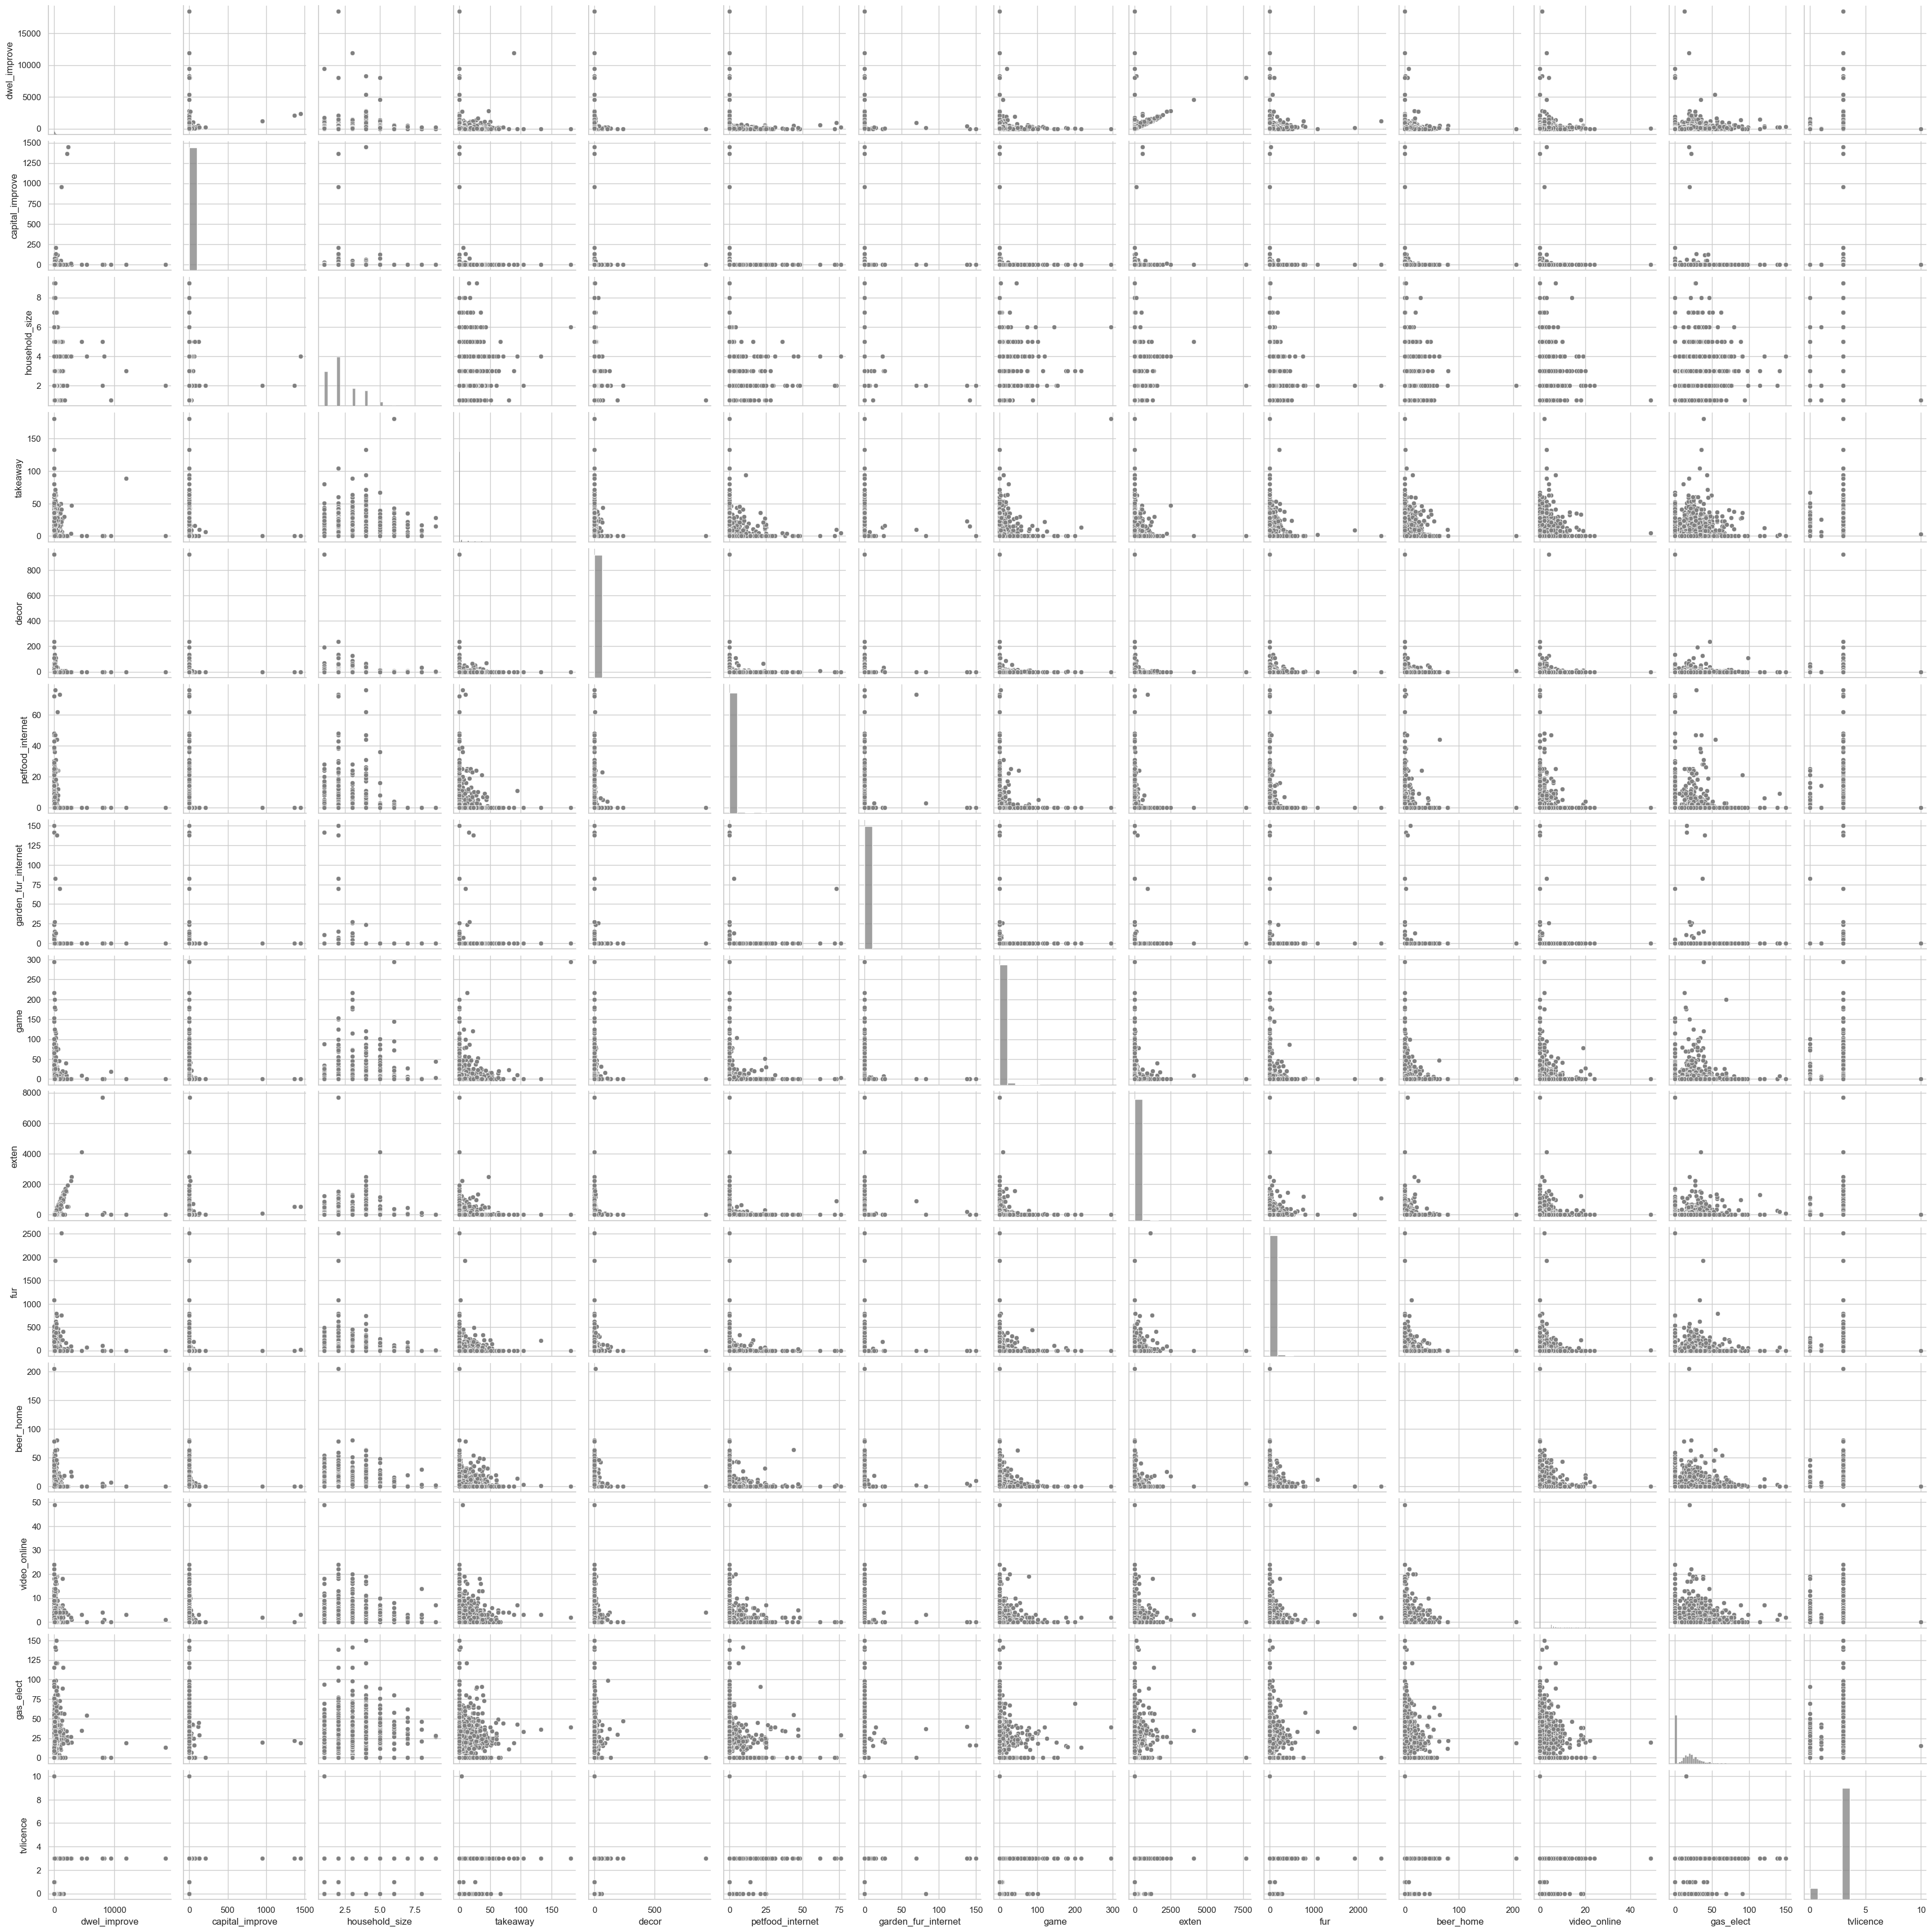

In [61]:
warnings.filterwarnings('ignore')

sns.set(style="whitegrid")
pairplot = sns.pairplot(new_df_transfered, 
                        plot_kws={'color': 'gray'},
                        diag_kws={'color': 'gray'})

plt.savefig("/Users/phoebeyang/Desktop/pairplot.png")
plt.show()

# 4. Association Rule Mining

## 4.1 Create and encode the t-database

In [97]:
data_transactions = data_standardized

# Transfer the data
transactions = data_transactions.apply(lambda x: x[x == 1].index.tolist(), axis=1).tolist()

# one-hot encode
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

## 4.2 Generate frequent itemsets and association rules

In [98]:
frequent_itemsets = apriori(df, min_support=0.01, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)
frequent_itemsets.to_csv('frequent_itemsets.txt', sep='\t', index=False)

print(f"Total number of itemsets: {len(frequent_itemsets)}")

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(['lift'], ascending=[False])

def format_itemset(itemset):
    return ', '.join(sorted(itemset))

rules['antecedents'] = rules['antecedents'].apply(format_itemset)
rules['consequents'] = rules['consequents'].apply(format_itemset)

rules = rules.reset_index(drop=True)
rules.index = rules.index + 1

print(rules)
print(f"Total number of rules: {len(rules)}")

rules.to_csv('association_rules.txt', sep='\t', index=True, index_label='Rule')

Total number of itemsets: 29
                  antecedents                consequents  antecedent support  \
1              household_size       gas_elect, tvlicence            0.019768   
2        gas_elect, tvlicence             household_size            0.014731   
3                   tvlicence  gas_elect, household_size            0.023576   
4   gas_elect, household_size                  tvlicence            0.012475   
5                   tvlicence             household_size            0.023576   
6              household_size                  tvlicence            0.019768   
7                    takeaway    dwel_improve, gas_elect            0.030719   
8     dwel_improve, gas_elect                   takeaway            0.067063   
9                   gas_elect  household_size, tvlicence            0.128520   
10  household_size, tvlicence                  gas_elect            0.016234   
11     dwel_improve, takeaway                  gas_elect            0.016448   
12         

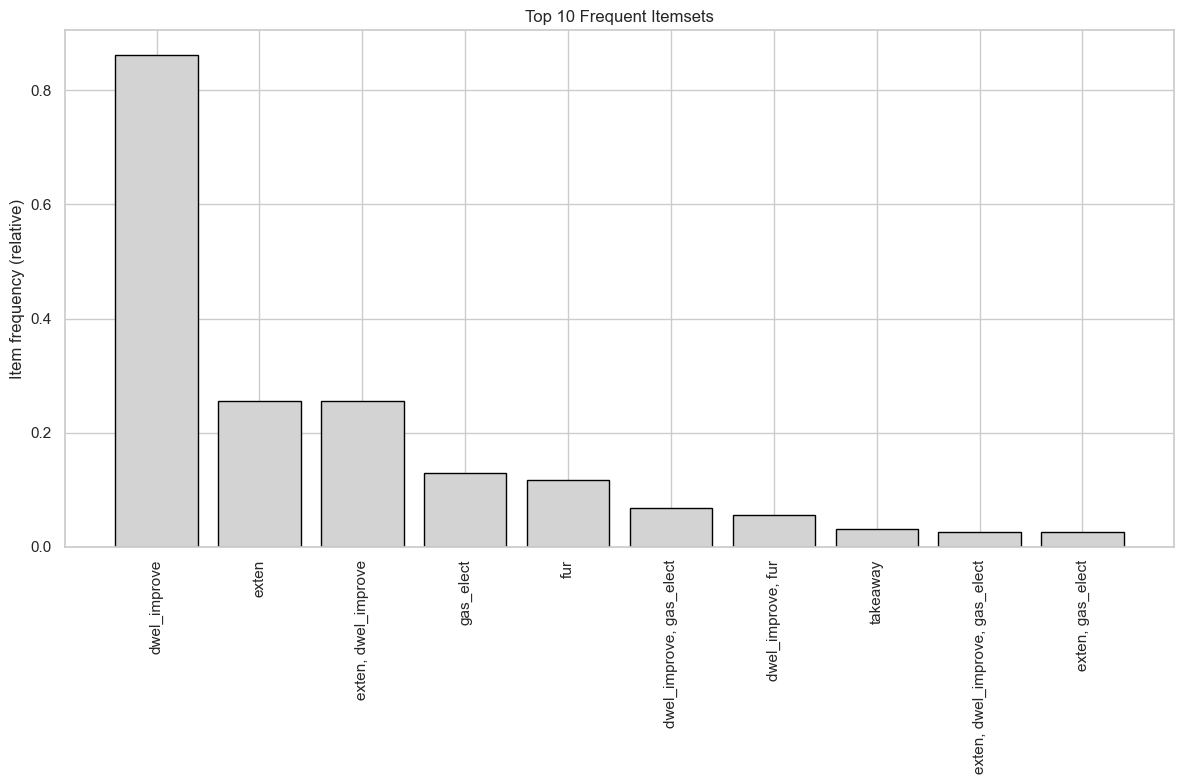

In [99]:
top_10 = frequent_itemsets.head(10)

plt.figure(figsize=(12, 8))
plt.bar(range(len(top_10)), top_10['support'], align='center', color='lightgray', edgecolor='black')

plt.xticks(range(len(top_10)), top_10['itemsets'].apply(lambda x: ', '.join(list(x))), rotation=90)
plt.ylabel('Item frequency (relative)')
plt.title('Top 10 Frequent Itemsets')

plt.tight_layout()
plt.savefig("/Users/phoebeyang/Desktop/Top 10 Frequent Itemsets.png")
plt.show()

# 5. Construct Bayesian Networks for each rule and compute BC and BL

## 5.1 Compute the BC and BL and add in the association rules

In [100]:
min_support = 0.01
rules = rules[rules['support'] >= min_support]
rules = rules[rules['lift'] > 1]

for index, rule in rules.iterrows():
    antecedents = rule['antecedents'].split(', ')
    consequents = rule['consequents'].split(', ')
    
    model = BayesianNetwork()
    
    for antecedent in antecedents:
        for consequent in consequents:
            model.add_edge(antecedent, consequent)
            
    model.fit(data_standardized, estimator=MaximumLikelihoodEstimator)
    
    inference = VariableElimination(model)
    
    # Calculate the probability of the antecedent and the consequent
    antecedent_probs = [inference.query(variables=[ant]).values[1] for ant in antecedents]
    consequent_probs = [inference.query(variables=[cons]).values[1] for cons in consequents]
    
    # Calculate joint probabilities
    joint_prob = inference.query(variables=antecedents + consequents)
    joint_prob_value = joint_prob.values[tuple([1] * len(antecedents + consequents))]
    
    # Calculate BC (Bayesian Confidence) with length penalty
    L = len(antecedents) + len(consequents)
    BC = (joint_prob_value / np.prod(antecedent_probs)) ** (1 / L)
    
    # Calculate BL (Bayesian Lifting)
    BL = BC / np.prod(consequent_probs)

    rules.at[index, 'BC'] = BC
    rules.at[index, 'BL'] = BL

# sorted by BC and BL
rules_sorted = rules.sort_values(by=['BC', 'BL'], ascending=False)

print("All rules ranked by BC and BL:")
print(rules_sorted[['antecedents', 'consequents', 'BC', 'BL', 'support', 'confidence', 'lift']])
print(f"Total number of rules: {len(rules)}")

rules_sorted.to_csv('all_association_rules.csv', index=False)

All rules ranked by BC and BL:
                  antecedents                consequents        BC  \
36                      exten               dwel_improve  1.000000   
35           exten, gas_elect               dwel_improve  1.000000   
33                 exten, fur               dwel_improve  1.000000   
4   gas_elect, household_size                  tvlicence  0.942875   
6              household_size                  tvlicence  0.906207   
2        gas_elect, tvlicence             household_size  0.892038   
10  household_size, tvlicence                  gas_elect  0.863624   
11     dwel_improve, takeaway                  gas_elect  0.860326   
5                   tvlicence             household_size  0.829796   
1              household_size       gas_elect, tvlicence  0.803231   
13             household_size                  gas_elect  0.794389   
15                  tvlicence                  gas_elect  0.790466   
18                  beer_home                  gas_elect  0

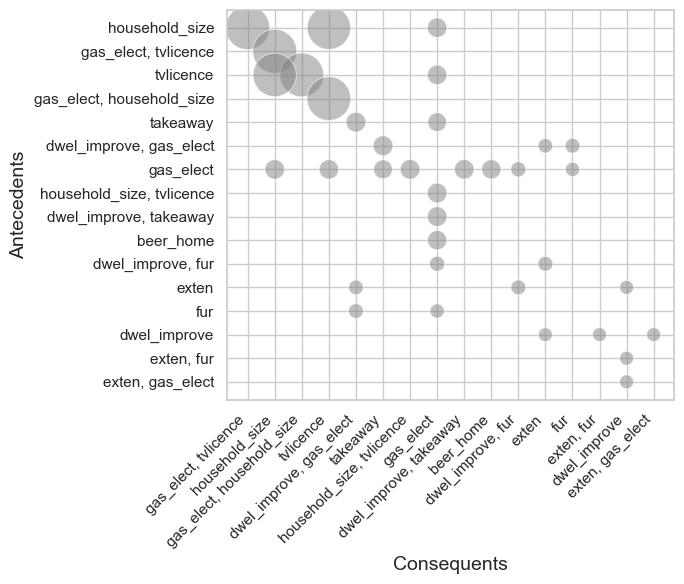

In [91]:
plt.figure(figsize=(7, 6)) 
sns.set(style="whitegrid")

bubble_plot = sns.scatterplot(
    data=rules,
    x='consequents',
    y='antecedents',
    size='lift',
    sizes=(100, 1000),
    color='gray',
    legend=False,
    alpha=0.5 
)

bubble_plot.set_xlabel('Consequents', fontsize=14)
bubble_plot.set_ylabel('Antecedents', fontsize=14)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig("/Users/phoebeyang/Desktop/Grouped Matrix for Association Rules.png")
plt.show()

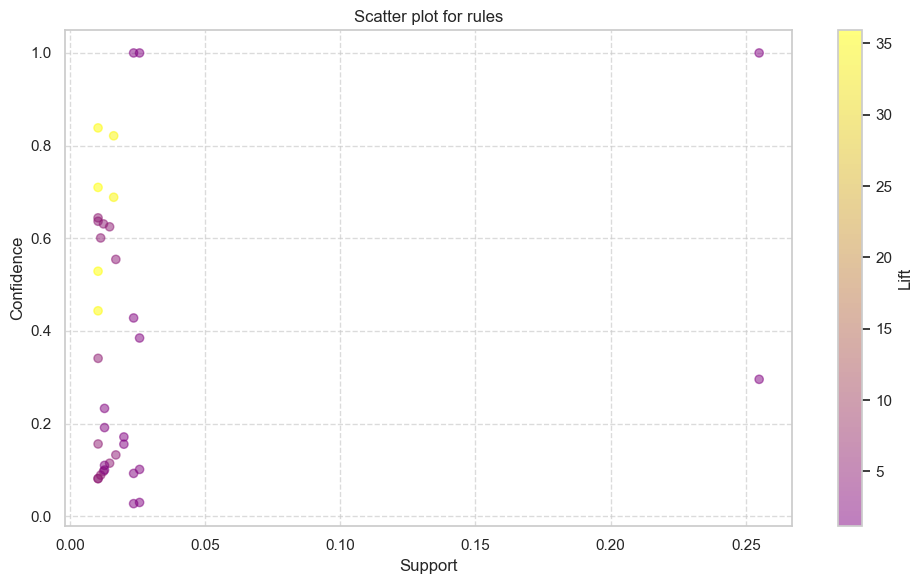

In [92]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

plt.figure(figsize=(10, 6))

colors = ['purple', 'yellow']
n_bins = 100
cmap_purple_yellow = LinearSegmentedColormap.from_list('purple_yellow', colors, N=n_bins)

scatter = plt.scatter(rules['support'], rules['confidence'], alpha=0.5, c=rules['lift'], cmap=cmap_purple_yellow)

plt.colorbar(scatter, label='Lift')
plt.xlabel('Support')
plt.ylabel('Confidence')

plt.title('Scatter plot for rules')
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("/Users/phoebeyang/Desktop/Scatter plot for rules.png")
plt.show()

## 5.2 Query conditional probability

In [93]:
model = BayesianNetwork([
    ('dwel_improve', 'gas_elect'),
    ('takeaway', 'gas_elect'),
])

model.fit(data_standardized, estimator=MaximumLikelihoodEstimator)

inference = VariableElimination(model)

variables = ['dwel_improve', 'takeaway']
target_variables = ['gas_elect']

for evidence_combo in [(0,0), (0,1), (1,0), (1,1)]:
    evidence = dict(zip(variables, evidence_combo))
    print(f"\nEvidence: {evidence}")
    
    for target in target_variables:
        result = inference.query(variables=[target], evidence=evidence)
        print(f"P({target} | {evidence}):")
        print(result)


Evidence: {'dwel_improve': 0, 'takeaway': 0}
P(gas_elect | {'dwel_improve': 0, 'takeaway': 0}):
+--------------+------------------+
| gas_elect    |   phi(gas_elect) |
+==============+==================+
| gas_elect(0) |           0.5559 |
+--------------+------------------+
| gas_elect(1) |           0.4441 |
+--------------+------------------+

Evidence: {'dwel_improve': 0, 'takeaway': 1}
P(gas_elect | {'dwel_improve': 0, 'takeaway': 1}):
+--------------+------------------+
| gas_elect    |   phi(gas_elect) |
+==============+==================+
| gas_elect(0) |           0.5404 |
+--------------+------------------+
| gas_elect(1) |           0.4596 |
+--------------+------------------+

Evidence: {'dwel_improve': 1, 'takeaway': 0}
P(gas_elect | {'dwel_improve': 1, 'takeaway': 0}):
+--------------+------------------+
| gas_elect    |   phi(gas_elect) |
+==============+==================+
| gas_elect(0) |           0.9331 |
+--------------+------------------+
| gas_elect(1) |         

In [94]:
model = BayesianNetwork([
    ('dwel_improve', 'exten'),
    ('fur', 'exten'),
])

model.fit(data_standardized, estimator=MaximumLikelihoodEstimator)

inference = VariableElimination(model)

variables = ['dwel_improve', 'fur']
target_variables = ['exten']

for evidence_combo in [(0,0), (0,1), (1,0), (1,1)]:
    evidence = dict(zip(variables, evidence_combo))
    print(f"\nEvidence: {evidence}")
    
    for target in target_variables:
        result = inference.query(variables=[target], evidence=evidence)
        print(f"P({target} | {evidence}):")
        print(result)


Evidence: {'dwel_improve': 0, 'fur': 0}
P(exten | {'dwel_improve': 0, 'fur': 0}):
+----------+--------------+
| exten    |   phi(exten) |
+==========+==============+
| exten(0) |       1.0000 |
+----------+--------------+
| exten(1) |       0.0000 |
+----------+--------------+

Evidence: {'dwel_improve': 0, 'fur': 1}
P(exten | {'dwel_improve': 0, 'fur': 1}):
+----------+--------------+
| exten    |   phi(exten) |
+==========+==============+
| exten(0) |       1.0000 |
+----------+--------------+
| exten(1) |       0.0000 |
+----------+--------------+

Evidence: {'dwel_improve': 1, 'fur': 0}
P(exten | {'dwel_improve': 1, 'fur': 0}):
+----------+--------------+
| exten    |   phi(exten) |
+==========+==============+
| exten(0) |       0.7134 |
+----------+--------------+
| exten(1) |       0.2866 |
+----------+--------------+

Evidence: {'dwel_improve': 1, 'fur': 1}
P(exten | {'dwel_improve': 1, 'fur': 1}):
+----------+--------------+
| exten    |   phi(exten) |
+==========+============

In [95]:
model = BayesianNetwork([
    ('dwel_improve', 'exten'),
    ('gas_elect', 'exten'),
])

model.fit(data_standardized, estimator=MaximumLikelihoodEstimator)

inference = VariableElimination(model)

variables = ['dwel_improve', 'gas_elect']
target_variables = ['exten']

for evidence_combo in [(0,0), (0,1), (1,0), (1,1)]:
    evidence = dict(zip(variables, evidence_combo))
    print(f"\nEvidence: {evidence}")
    
    for target in target_variables:
        result = inference.query(variables=[target], evidence=evidence)
        print(f"P({target} | {evidence}):")
        print(result)


Evidence: {'dwel_improve': 0, 'gas_elect': 0}
P(exten | {'dwel_improve': 0, 'gas_elect': 0}):
+----------+--------------+
| exten    |   phi(exten) |
+==========+==============+
| exten(0) |       1.0000 |
+----------+--------------+
| exten(1) |       0.0000 |
+----------+--------------+

Evidence: {'dwel_improve': 0, 'gas_elect': 1}
P(exten | {'dwel_improve': 0, 'gas_elect': 1}):
+----------+--------------+
| exten    |   phi(exten) |
+==========+==============+
| exten(0) |       1.0000 |
+----------+--------------+
| exten(1) |       0.0000 |
+----------+--------------+

Evidence: {'dwel_improve': 1, 'gas_elect': 0}
P(exten | {'dwel_improve': 1, 'gas_elect': 0}):
+----------+--------------+
| exten    |   phi(exten) |
+==========+==============+
| exten(0) |       0.7118 |
+----------+--------------+
| exten(1) |       0.2882 |
+----------+--------------+

Evidence: {'dwel_improve': 1, 'gas_elect': 1}
P(exten | {'dwel_improve': 1, 'gas_elect': 1}):
+----------+--------------+
| ex